In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Getting the observations for the selected stations

In [2]:
p = Path('../../data/ncdc')
observationsCSV = p.joinpath('observations_vlc.csv')
print ('Reading observations CSV')
dfObs = pd.read_csv(str(observationsCSV),index_col=0)
print ("{:,} observations".format(len(dfObs)))

Reading observations CSV
366 observations


In [3]:
dfObs.head()

,stn,wban,year,monthday,temp,temp_count,dewp,dewp_count,slp,slp_count,...,gust,max,max_flag,min,min_flag,prcp,prc_flag,sndp,frshtt,koppen
0,82840,99999,1996,101,63.3,24,47.5,24,1005.0,24,...,49.9,70.7,NaN,56.5,NaN,0,D,999.9,0,BSk
1,82840,99999,1996,102,59.0,23,40.9,23,1016.3,23,...,999.9,68.9,NaN,48.2,*,0,D,999.9,0,BSk
2,82840,99999,1996,103,52.8,24,40.9,24,1018.1,24,...,999.9,66.2,NaN,46.9,NaN,0,D,999.9,0,BSk
3,82840,99999,1996,104,51.1,24,46.6,24,1015.0,24,...,999.9,60.8,NaN,44.6,*,0,D,999.9,0,BSk
4,82840,99999,1996,105,56.2,24,46.2,24,1005.1,24,...,999.9,65.1,*,50.0,*,0,E,999.9,10000,BSk


### Data management operations

Generate an index using the id station and the date

In [4]:
def getId(stn,wban):
    try:
        istn = int(stn)
        iwban = int(wban)
        return "{:0>6}-{:0>5}".format(istn,iwban)
    except ValueError:
        print("{}/{}".format(stn,wban))
        
def getStationByStnWban(stn,wban):
    try:
        koppen = scdfc.loc[getId(stn,wban)].koppen
    except KeyError:
        koppen = None
    return koppen   
def getDateTimeFromRow(row):
    try:
        iyear = int(row.year)
        imonth = int("{:0>4}".format(row.monthday)[0:2])
        iday = int("{:0>4}".format(row.monthday)[2:4])
        return  datetime(iyear,imonth,iday)
    except ValueError:
        return np.nan

dfObs['date'] = dfObs.apply(lambda row : getDateTimeFromRow(row),axis=1)
dfObs.set_index(['date'],inplace=True)

The `frshtt` column needs to be padded with zeros to get all the flags in the correct place. Then is possible to get the occurrence of different weather conditions

In [5]:
dfObs['frshtt']  = dfObs.apply(lambda row: "{:0>6}".format(row.frshtt),axis=1)
dfObs['fog']     = dfObs['frshtt'].apply(lambda row: row[0:1]=='1')
dfObs['rain']    = dfObs['frshtt'].apply(lambda row: row[1:2]=='1')
dfObs['snow']    = dfObs['frshtt'].apply(lambda row: row[2:3]=='1')
dfObs['hail']    = dfObs['frshtt'].apply(lambda row: row[3:4]=='1')
dfObs['thunder'] = dfObs['frshtt'].apply(lambda row: row[4:5]=='1')
dfObs['tornado'] = dfObs['frshtt'].apply(lambda row: row[5:6]=='1')

Recode the temperatures columns, replacing the NaN values and afterwards as numerics

In [6]:
dfObs['tempC'] = dfObs['temp'].replace('99.9', np.nan)
dfObs['maxC']  = dfObs['max'].replace('99.9', np.nan)
dfObs['minC']  = dfObs['min'].replace('99.9', np.nan)

dfObs['tempC'] = pd.to_numeric(dfObs['tempC'])
dfObs['maxC']  = pd.to_numeric(dfObs['maxC'])
dfObs['minC']  = pd.to_numeric( dfObs['minC']) 

def FtoC(f):
    return (f-32)*5/9

dfObs['tempC']= dfObs['tempC'].apply(lambda temp: FtoC(temp))
dfObs['maxC'] = dfObs['maxC'].apply(lambda temp: FtoC(temp))
dfObs['minC'] = dfObs['minC'].apply(lambda temp: FtoC(temp))

In [7]:
dfObs.head()

,stn,wban,year,monthday,temp,temp_count,dewp,dewp_count,slp,slp_count,...,koppen,fog,rain,snow,hail,thunder,tornado,tempC,maxC,minC
date,,,,,,,,,,,,,,,,,,,,,
1996-01-01,82840,99999,1996,101,63.3,24,47.5,24,1005.0,24,...,BSk,False,False,False,False,False,False,17.388889,21.500000,13.611111
1996-01-02,82840,99999,1996,102,59.0,23,40.9,23,1016.3,23,...,BSk,False,False,False,False,False,False,15.000000,20.500000,9.000000
1996-01-03,82840,99999,1996,103,52.8,24,40.9,24,1018.1,24,...,BSk,False,False,False,False,False,False,11.555556,19.000000,8.277778
1996-01-04,82840,99999,1996,104,51.1,24,46.6,24,1015.0,24,...,BSk,False,False,False,False,False,False,10.611111,16.000000,7.000000
1996-01-05,82840,99999,1996,105,56.2,24,46.2,24,1005.1,24,...,BSk,False,True,False,False,False,False,13.444444,18.388889,10.000000


## Univariate visualization

In [8]:
%matplotlib inline
df = dfObs.copy()

### Quantitative variables

In [9]:
df[['tempC','maxC','minC']].describe()

,tempC,maxC,minC
count,366.000000,366.000000,366.000000
mean,17.201275,22.711900,12.636612
std,5.579117,5.829933,5.459917
min,5.444444,8.388889,0.000000
25%,12.513889,18.000000,8.388889
50%,16.888889,22.750000,12.500000
75%,21.666667,27.361111,17.000000
max,28.388889,37.000000,24.777778


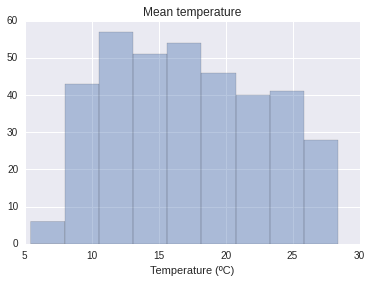

In [10]:
sns.distplot(df["tempC"].dropna(), kde=False);
plt.xlabel('Temperature (ºC)')
plt.title('Mean temperature')

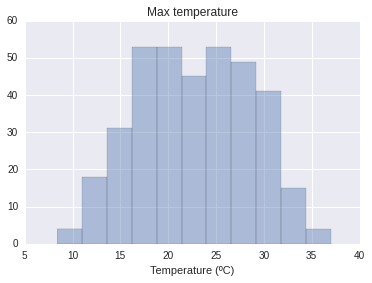

In [11]:
sns.distplot(df["maxC"].dropna(), kde=False);
plt.xlabel('Temperature (ºC)')
plt.title('Max temperature')

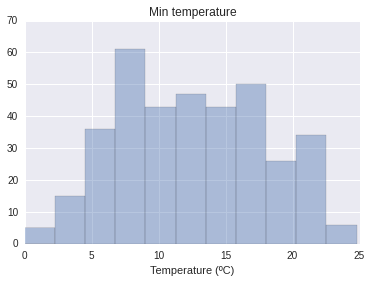

In [12]:
sns.distplot(df["minC"].dropna(), kde=False);
plt.xlabel('Temperature (ºC)')
plt.title('Min temperature')

Plotting the three variables together

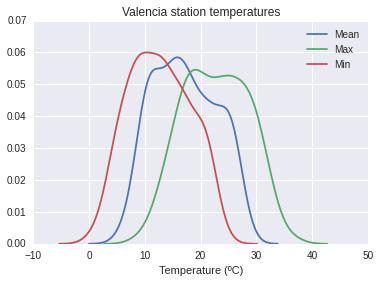

In [13]:
sns.kdeplot(df.tempC, label="Mean")
sns.kdeplot(df.maxC, label="Max")
sns.kdeplot(df.minC, label="Min")
plt.legend();
plt.xlabel('Temperature (ºC)')
plt.title('Valencia station temperatures')

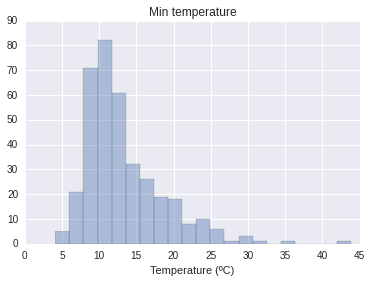

In [26]:
sns.distplot(df["mxspd"].dropna(), kde=False);
plt.xlabel('Temperature (ºC)')
plt.title('Min temperature')

### Cualitative variables

Our quantitative variables are all `True/False` so they are categorical by definition

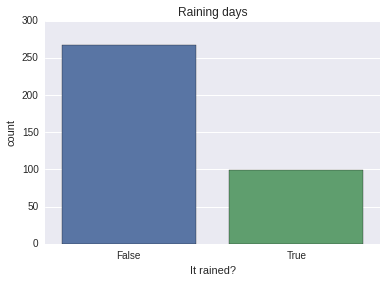

In [15]:
sns.countplot(x="rain", data=df);
plt.xlabel('It rained?')
plt.title('Raining days')

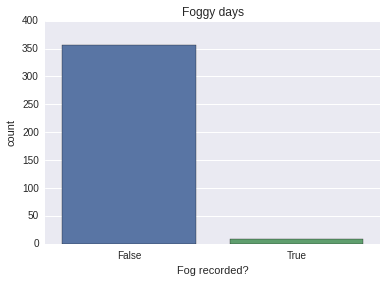

In [16]:
sns.countplot(x="fog", data=df);
plt.xlabel('Fog recorded?')
plt.title('Foggy days')

## Bivariate visualizations

Let's compare temperature and rainy days (quantitative to cualitative)

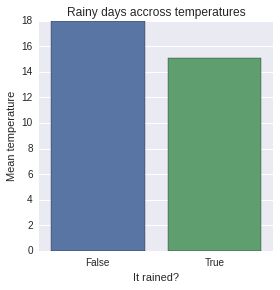

In [17]:
sns.factorplot(x="rain", y="tempC", data=df, kind="bar", ci=None)
plt.xlabel('It rained?')
plt.ylabel('Mean temperature')
plt.title('Rainy days accross temperatures')

What about pressure and rainy days?

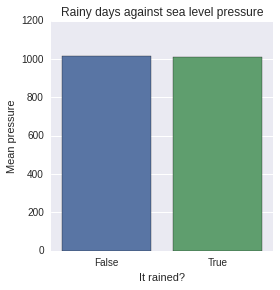

In [18]:
sns.factorplot(x="rain", y="slp", data=df, kind="bar", ci=None)
plt.xlabel('It rained?')
plt.ylabel('Mean pressure')
plt.title('Rainy days against sea level pressure')

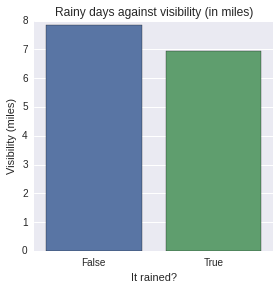

In [19]:
sns.factorplot(x="rain", y="visib", data=df, kind="bar", ci=None)
plt.xlabel('It rained?')
plt.ylabel('Visibility (miles)')
plt.title('Rainy days against visibility (in miles)')

Let's compare sea level presure and temperatures using a scatter plot

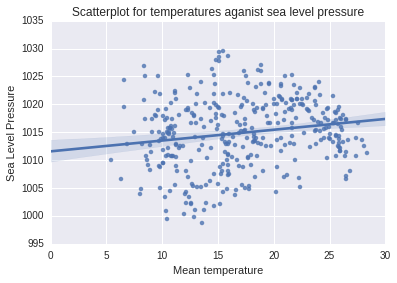

In [20]:
sns.regplot(x="tempC", y="slp", data=df)
plt.xlabel('Mean temperature')
plt.ylabel('Sea Level Pressure')
plt.title('Scatterplot for temperatures aganist sea level pressure')

What about using the measured precipitations?

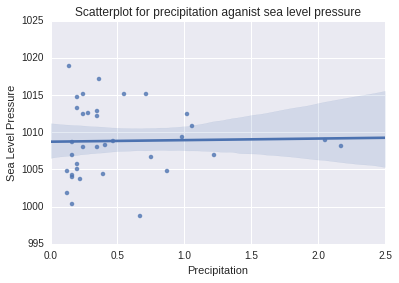

In [21]:
sns.regplot(x="prcp", y="slp", data=df[(df.prcp>0.1)])
plt.xlabel('Precipitation')
plt.ylabel('Sea Level Pressure')
plt.title('Scatterplot for precipitation aganist sea level pressure')

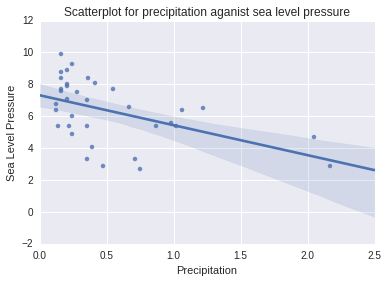

In [22]:
sns.regplot(x="prcp", y="visib", data=df[(df.prcp>0.1)])
plt.xlabel('Precipitation')
plt.ylabel('Sea Level Pressure')
plt.title('Scatterplot for precipitation aganist sea level pressure')